In [1]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
#%matplotlib notebook
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import cProfile
import pstats
import io
from pstats import SortKey
import random
import pandas_ta as ta

In [60]:
nifty = pd.read_csv('./data_1990_2020/index_data/NIFTY_50.csv')
nifty = nifty[nifty['Open']!=0]
nifty.reset_index(drop=True,inplace=True)

In [61]:
nifty

,Date,Open,High,Low,Close,Volume,Turnover
0,1995-11-03,994.20,1000.91,992.69,1000.00,NaN,NaN
1,1995-11-06,1001.53,1001.53,988.92,988.92,NaN,NaN
2,1995-11-07,987.17,987.17,977.05,978.22,NaN,NaN
3,1995-11-08,976.28,976.28,962.98,964.01,NaN,NaN
4,1995-11-09,960.32,960.32,952.13,953.07,NaN,NaN
...,...,...,...,...,...,...,...
6258,2020-12-24,13672.15,13771.75,13626.90,13749.25,471367730.0,2.476435e+11
6259,2020-12-28,13815.15,13885.30,13811.55,13873.20,403634030.0,2.092306e+11
6260,2020-12-29,13910.35,13967.60,13859.90,13932.60,439593961.0,2.515423e+11
6261,2020-12-30,13980.90,13997.00,13864.95,13981.95,380681073.0,2.463312e+11


In [81]:
tl=75
c2 = pd.DataFrame(columns=['Date','Balance','BoughtAt','SoldAt','Profloss','Price','Proflossperc'])
c2['Date'] = nifty['Date']
c2['BoughtAt'] = 0
c2['SoldAt'] = 0
c2['Profloss'] = 0
c2['Price'] = 0
c2['Balance'] = 0
c3 = pd.DataFrame(columns=['Target','Stoplossval','POP','Net return','Annualized return','Mean profit','Mean loss','Max Drawdown'])
c4 = pd.DataFrame(columns=['Superlength','Supermult','POP','Net return','Annualized return','Mean profit','Mean loss','Max Drawdown'])
a=list(range(1,11))*10
c4['Superlength']=[1]#[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,1]
a.sort()
c4['Supermult']=[2]#[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2]
# mins = 15
# tl=int(375/mins)
#c3['Stoplossval'] = [1]#[0.001]#np.linspace(0, 0.004, 17)
c3['Stoplossval'] = [1]
# b = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]*10
# b.sort()
# c3['Target'] = b
pn=0
ln=0
b=len(nifty)
a=0
perctgt=0.1
mintgt=0.025
m=0
mw=0.5
flag=0

def sell(i,tgt,slp):
    global b,pn,ln,tl,slip,leverage,n,perctgt,c2,c3,nifty,m,flag
    k=i+1
    for k in range(i+1,b-1):
        if nifty['Low'][k]<tgt:            
            pn+=1
            c2.at[k,'BoughtAt'] = tgt
            c2.at[k,'Profloss'] = n*(slp-tgt)*leverage-nifty['Close'][k]*slip*n
            c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
            c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
            #print('1 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
            return k
        if nifty['Close'][k]>nifty['Supertrend'][k]:
            ln+=1
            c2.at[k,'BoughtAt'] = nifty['Close'][k]
            c2.at[k,'Profloss'] = n*(slp-nifty['Close'][k])*leverage-nifty['Close'][k]*slip*n
            c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
            c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
            c2.loc[k+1:b, 'Balance'] = c2.at[k+1, 'Balance']
            #print('1.5 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
            if ((nifty['Supertrend'][k-1]*(1+perctgt)-nifty['Close'][k])>mintgt*nifty['Supertrend'][k-1]):
                #print('2 On {}:{}; Bought twice at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
                return buy(k,nifty['Supertrend'][k-1]*(1+perctgt),nifty['Close'][k])
            else:
                return k
        if nifty['Close'][k]>slp*(1+c3.loc[m,'Stoplossval']):
            ln+=1
            c2.at[k,'BoughtAt'] = nifty['Close'][k]
            c2.at[k,'Profloss'] = n*(slp-nifty['Close'][k])*leverage-nifty['Close'][k]*slip*n 
            c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
            c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
            #print('2 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
            return k
    c2.at[k,'BoughtAt'] = nifty['Close'][k]
    c2.at[k,'Profloss'] = n*(slp-nifty['Close'][k])*leverage-nifty['Close'][k]*slip*n
    c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
    c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
    #print('3 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
    if c2.at[k,'Profloss']>0:
        pn+=1
    else:
        ln+=1
    return k

def buy(i,tgt,byp):
    global b,pn,ln,tl,slip,leverage,n,perctgt,c2,c3,nifty,m,flag
    k=i+1
    for k in range(i+1,b-1):
        if nifty['High'][k]>tgt:
            pn+=1
            c2.at[k,'SoldAt'] = tgt
            c2.at[k,'Profloss'] = n*(tgt-byp)*leverage-nifty['Close'][k]*slip*n
            c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
            c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
            #print('4 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
            return k
        if nifty['Close'][k]<nifty['Supertrend'][k]:            
            ln+=1
            c2.at[k,'SoldAt'] = nifty['Close'][k]
            c2.at[k,'Profloss'] = n*(nifty['Close'][k]-byp)*leverage-nifty['Close'][k]*slip*n
            c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
            c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
            c2.loc[k+1:b, 'Balance'] = c2.at[k+1, 'Balance']
            if ((nifty['Close'][k]-nifty['Supertrend'][k-1]*(1-perctgt))>mintgt*nifty['Supertrend'][k-1]):
                #print('5 On {}:{}; Sold twice at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
                return sell(k,nifty['Supertrend'][k-1]*(1-perctgt),nifty['Close'][k])
            else:
                return k
        if nifty['Close'][k]<byp*(1-c3.loc[m,'Stoplossval']):
            ln+=1
            c2.at[k,'SoldAt'] = nifty['Close'][k]
            c2.at[k,'Profloss'] = n*(c2.loc[k,'SoldAt']-byp)*leverage-nifty['Close'][k]*slip*n
            c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
            c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
            #print('5 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss']))
            return k
    c2.at[k,'SoldAt'] = nifty['Close'][k]
    c2.at[k,'Profloss'] = n*(nifty['Close'][k]-byp)*leverage-nifty['Close'][k]*slip*n
    c2.loc[i:k+1, 'Balance'] = c2.at[i,'Balance'] 
    c2.at[k+1, 'Balance'] += c2.at[k,'Profloss']
    #print('6 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f} k:{},j:{}'.format(c2.loc[k,'Date'],c2.loc[k,'Time'],c2.loc[k,'BoughtAt'],c2.loc[k,'SoldAt'],c2.loc[k,'Profloss'],k,j))
    if c2.at[k,'Profloss']>0:
        pn+=1
    else:
        ln+=1
    return k

k=0

for q in [0]:
    for m in range(len(c3['Stoplossval'])):
        #perctgt=c3.loc[m,'Target']
        #mintgt=perctgt/4.0
        daysconsidered=b-a
        
        nifty['Supertrend'] = ta.supertrend(nifty['High'], nifty['Low'], nifty['Close'],length=c4.at[q,'Superlength'],multiplier=c4.at[q,'Supermult'])['SUPERT_'+str(c4.at[q,'Superlength'])+'_'+str(c4.at[q,'Supermult'])+'.0']
           
        c2.at[a,'Balance'] = round(100*nifty['Open'][a],-4)
        
        slippage=0

        ini=c2.at[a, 'Balance']
        balance=ini
        tgt=0.0
        sl=0.0
        leverage=1
        slip=slippage/100
        
        for i in range(a+1,b):
            n=balance/nifty['Open'][i] #n=math.floor(balance/nifty['Open'][i])
            
#             if flag==1:
#                 n=n*(mw)
            
            if n<1:
                print(c2['Date'][i+j])
                print('Total Loss n ')
                break
                
            if i<k+1:
                #c2.loc[i, 'Balance'] = c2.at[i-1, 'Balance']
                continue  
                
            k=0
            
#             try:
#                 if c2[c2['Profloss']!=0]['Profloss'].values[-1]<0:
#                     n=n*0.1
#             except:
#                 pass

            if min(nifty['Open'][i-1],nifty['Close'][i-1])>nifty['Supertrend'][i-1]:
                if (nifty['Close'][i]-nifty['Supertrend'][i-1]*(1-perctgt))>mintgt*nifty['Supertrend'][i-1] and nifty['Close'][i]<nifty['Supertrend'][i-1]:
                    slp=nifty['Close'][i]
                    tgt=nifty['Supertrend'][i-1]*(1-perctgt)
                    #print('Sent sell command from main func on {}'.format(nifty['Date'][i]))
                    k = sell(i,tgt,slp) 
                    #print(k)
                    c2.at[i,'SoldAt'] = slp
                    continue 

            if max(nifty['Open'][i-1],nifty['Close'][i-1])<nifty['Supertrend'][i-1]:
                if (nifty['Supertrend'][i-1]*(1+perctgt)-nifty['Close'][i])>mintgt*nifty['Supertrend'][i-1] and nifty['Close'][i]>nifty['Supertrend'][i-1]:
                    byp=nifty['Close'][i]
                    tgt=nifty['Supertrend'][i-1]*(1+perctgt)
                    #print('Sent buy command from main func on {}:{}'.format(nifty['Date'][i+j],nifty['Time'][i+j]))
                    k = buy(i,tgt,byp)                       
                    c2.at[i,'BoughtAt'] = byp
                    continue                         
                        
            balance = c2.loc[k, 'Balance']
            if balance<0:
                print(c2['Date'][i])
                print('Total Loss')
                break
                
        if i>a:
        c2.loc[i+1, 'Balance'] = c2.at[i,'Balance'] 

        res=(balance-ini)/ini
        Roll_Max = c2['Balance'][a:b].cummax()
        Daily_Drawdown = c2['Balance'][a:b]/Roll_Max - 1.0
        Max_Daily_Drawdown = Daily_Drawdown.cummin()
        max_drawdown=100*min(np.array(Max_Daily_Drawdown))
        if (ln+pn)>0:
            pop=100*pn/(ln+pn)
        else:
            pop=0
        net_return=res*100
        if res>0:
            annual_return=100*(pow(10,math.log(1+res,10)/(daysconsidered/234))-1)
        else:
            annual_return=0
        c2['Profloss']=c2['Profloss'].fillna(0)
        c2['Proflossperc']=100*c2['Profloss']/c2['Balance']
        c2['Proflossperc'] = c2['Proflossperc'].fillna(0)
        print('Number of profits:{} and number of losses:{}'.format(pn,ln))
        print('Max Drawdown: {:.2f}% , Probability of profit: {:.2f}%'.format(max_drawdown,pop))
        print('Net return: {:.2f}%, annualized: {:.2f}% stoplossval:{:.2f}%'.format(net_return,annual_return,c3.loc[m,'Stoplossval']*100))
        print('Mean profit {:.2f}%'.format(c2[c2['Proflossperc']>0]['Proflossperc'].mean()))
        print('Mean loss {:.2f}%\n\n'.format(c2[c2['Proflossperc']<0]['Proflossperc'].mean()))
        pn=0
        ln=0
        c3.at[m,'POP'] = pop
        c3.at[m,'Net return'] = net_return
        c3.at[m,'Annualized return'] = annual_return
        c3.at[m,'Mean profit'] = c2[c2['Proflossperc']>0]['Proflossperc'].mean()
        c3.at[m,'Mean loss'] = c2[c2['Proflossperc']<0]['Proflossperc'].mean()
        c3.at[m,'Max Drawdown'] = max_drawdown
        c2['BoughtAt']=c2['BoughtAt'].fillna(0)
        c2['SoldAt']=c2['SoldAt'].fillna(0)
        
#         c4.at[q,'POP'] = pop
#         c4.at[q,'Net return'] = net_return
#         c4.at[q,'Annualized return'] = annual_return
#         c4.at[q,'Mean profit'] = c2[c2['Proflossperc']>0]['Proflossperc'].mean()
#         c4.at[q,'Mean loss'] = c2[c2['Proflossperc']<0]['Proflossperc'].mean()
#         c4.at[q,'Max Drawdown'] = max_drawdown

#         c2['BoughtAt'] = 0
#         c2['SoldAt'] = 0
#         c2['Profloss'] = 0
#         c2['Balance'] = 0

c3['Stoplossval']=c3['Stoplossval']*100

Number of profits:83 and number of losses:401
Max Drawdown: -100.00% , Probability of profit: 17.15%
Net return: 0.00%, annualized: 0.00% stoplossval:100.00%
Mean profit inf%
Mean loss -0.89%




In [82]:
c2[:25]

,Date,Balance,BoughtAt,SoldAt,Profloss,Price,Proflossperc
0,1995-11-03,100000.00000,0.0000,0.00,0.00000,0.0,0.0
1,1995-11-06,0.00000,0.0000,0.00,0.00000,0.0,0.0
2,1995-11-07,0.00000,0.0000,0.00,0.00000,0.0,0.0
3,1995-11-08,0.00000,0.0000,964.01,0.00000,0.0,0.0
4,1995-11-09,0.00000,0.0000,0.00,0.00000,0.0,0.0
5,1995-11-10,0.00000,0.0000,0.00,0.00000,0.0,0.0
6,1995-11-13,0.00000,0.0000,0.00,0.00000,0.0,0.0
7,1995-11-14,0.00000,0.0000,0.00,0.00000,0.0,0.0
8,1995-11-15,0.00000,0.0000,0.00,0.00000,0.0,0.0
9,1995-11-16,0.00000,0.0000,0.00,0.00000,0.0,0.0


<Figure size 7680x5760 with 0 Axes>

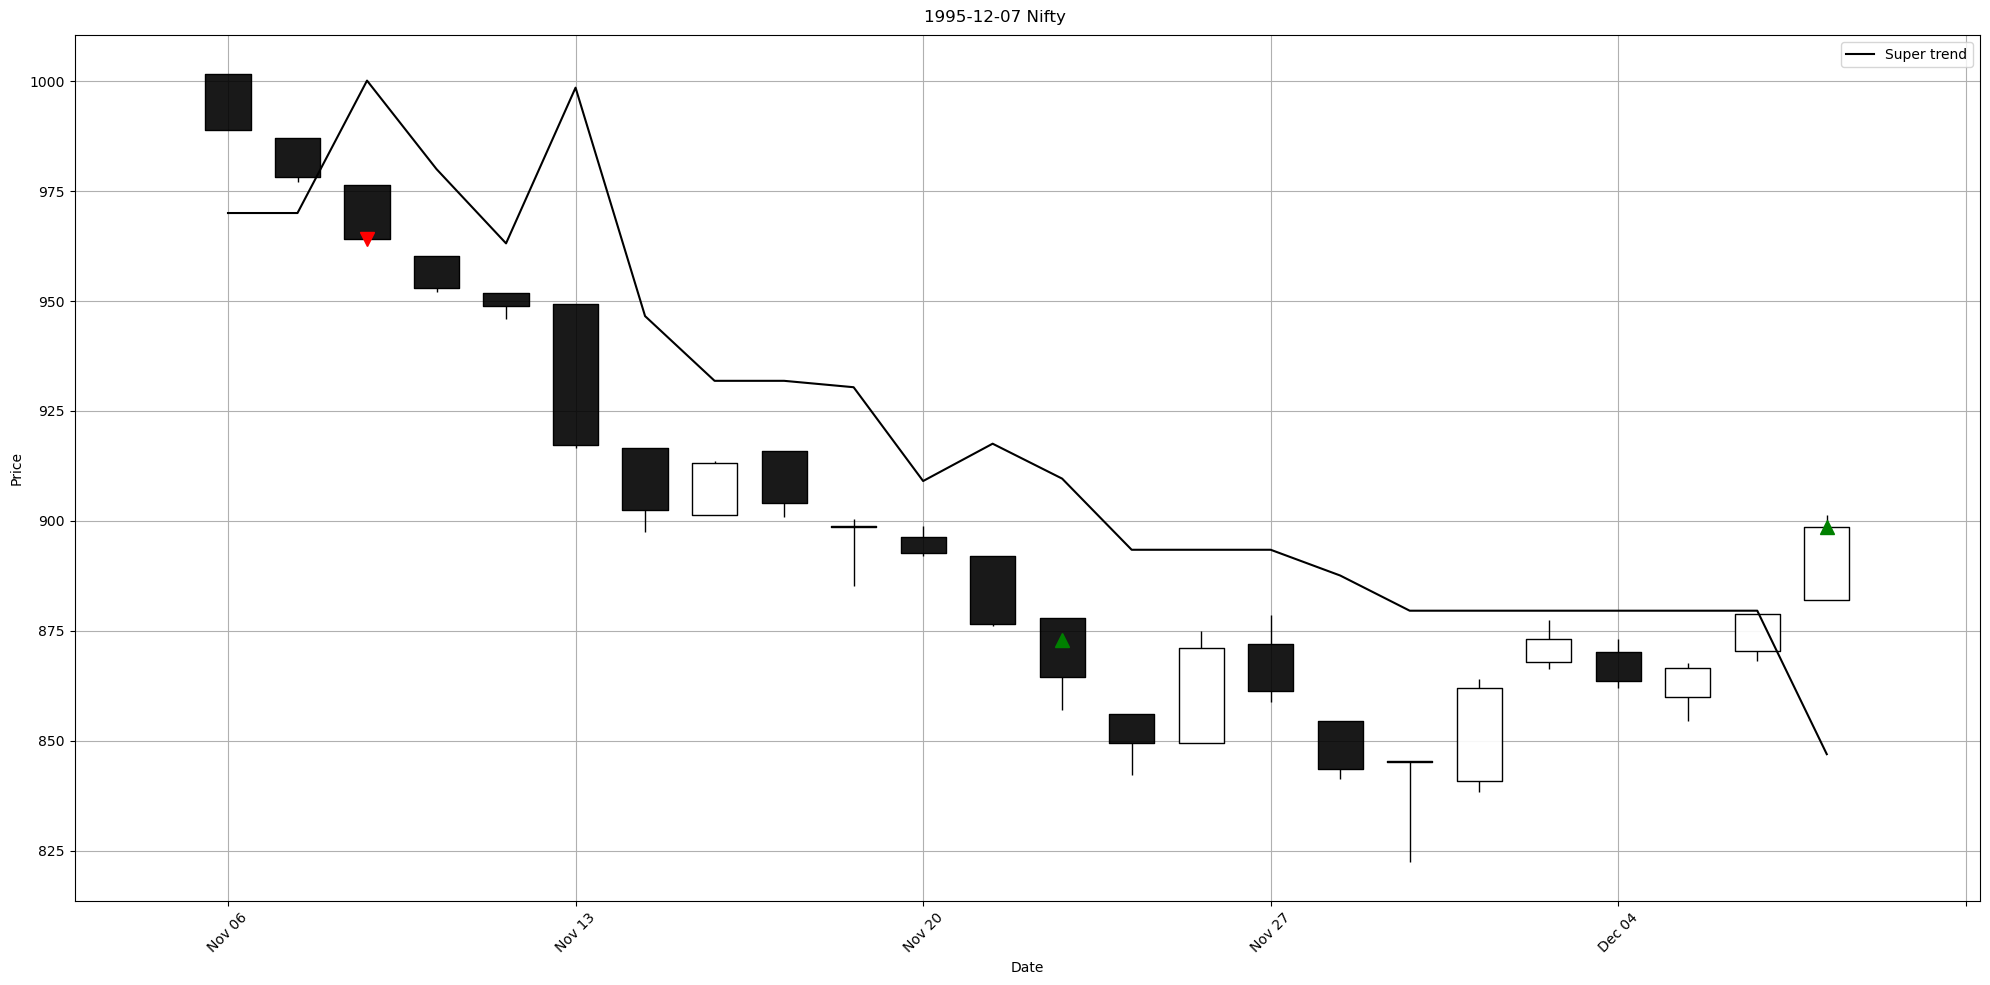

In [73]:
a=1
b=25
plotnifty=nifty.copy()
plotnifty.index= pd.to_datetime(plotnifty['Date'])
buytr = np.array(c2['BoughtAt'])
selltr = np.array(c2['SoldAt'])
buytr[ buytr==0 ] = np.nan
selltr[ selltr==0 ] = np.nan
c2['BoughtAt'] = buytr 
c2['SoldAt'] = selltr
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(20,10))
mc = mpf.make_marketcolors(up='w',down='k')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[a:b], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['Supertrend'][a:b].values,'k',label='Super trend')
#plt.plot(c2['Balance'][a*75::f].values,'b',label='5 minute Balance')
plt.plot(c2['BoughtAt'][a:b].values,'g^',markersize=10)
plt.plot(c2['SoldAt'][a:b].values,'rv',markersize=10)
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle(str(nifty[a:b]['Date'].iat[-1])+' '+'Nifty')
fig.tight_layout()
plt.grid()
plt.legend()
#c2[c2['Date']=='12-01-2018'].to_csv('test.csv')
#c2[c2['Date']==trading_days[day]].to_csv('test.csv')

In [75]:
c2

,Date,Balance,BoughtAt,SoldAt,Profloss,Price,Proflossperc
0,1995-11-03,100000.000000,NaN,NaN,0.000000,0,0.000000
1,1995-11-06,0.000000,NaN,NaN,0.000000,0,0.000000
2,1995-11-07,0.000000,NaN,NaN,0.000000,0,0.000000
3,1995-11-08,0.000000,NaN,964.01,0.000000,0,0.000000
4,1995-11-09,0.000000,NaN,NaN,0.000000,0,0.000000
...,...,...,...,...,...,...,...
6258,2020-12-24,308584.751182,NaN,NaN,0.000000,0,0.000000
6259,2020-12-28,308584.751182,NaN,NaN,0.000000,0,0.000000
6260,2020-12-29,308584.751182,13932.6,NaN,-4396.771917,0,-1.424818
6261,2020-12-30,308584.751182,NaN,13981.95,359.120646,0,0.116377


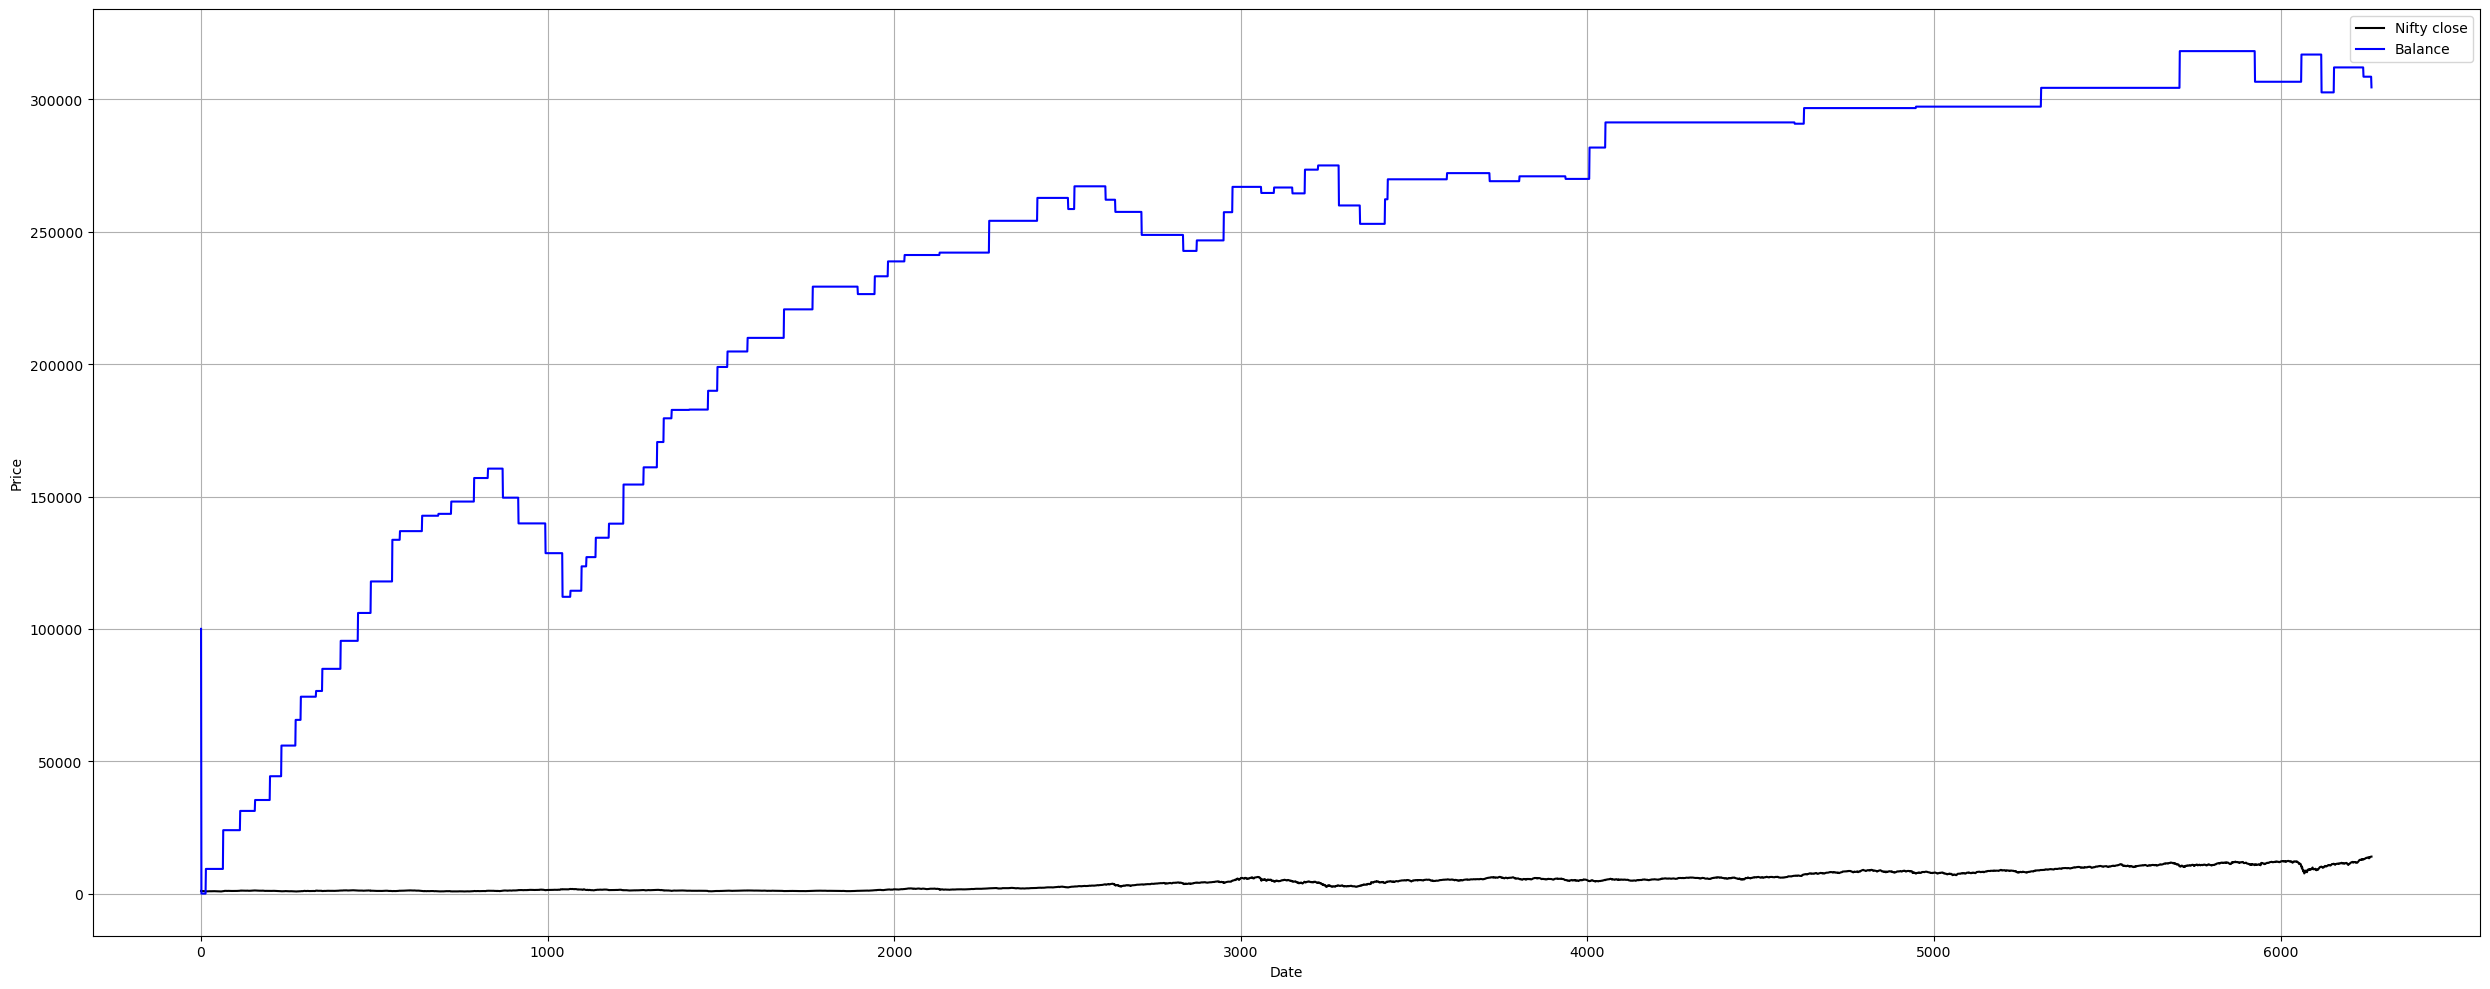

In [74]:
fig, ax = plt.subplots(figsize=(25,10))
plt.plot(nifty['Close'].values,'k',label='Nifty close')
plt.plot(c2['Balance'].values,'b',label='Balance')
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.tight_layout()
plt.grid()
plt.legend()
#plt.yscale("log")

In [36]:
c2[c2['BoughtAt']==0]['BoughtAt'] = np.nan

In [37]:
c2

,Date,Balance,BoughtAt,SoldAt,Profloss,Price,Proflossperc
0,1995-11-03,100000.000000,0.0,0.00,0.000000,0,0.000000
1,1995-11-06,100000.000000,0.0,0.00,0.000000,0,0.000000
2,1995-11-07,100000.000000,0.0,0.00,0.000000,0,0.000000
3,1995-11-08,100000.000000,0.0,964.01,0.000000,0,0.000000
4,1995-11-09,0.000000,0.0,0.00,0.000000,0,0.000000
...,...,...,...,...,...,...,...
6258,2020-12-24,-449413.285839,0.0,0.00,0.000000,0,-0.000000
6259,2020-12-28,-449413.285839,0.0,0.00,0.000000,0,-0.000000
6260,2020-12-29,-449413.285839,13932.6,0.00,-4396.771917,0,0.978336
6261,2020-12-30,-453810.057756,0.0,13981.95,359.120646,0,-0.079135


<Figure size 7680x5760 with 0 Axes>

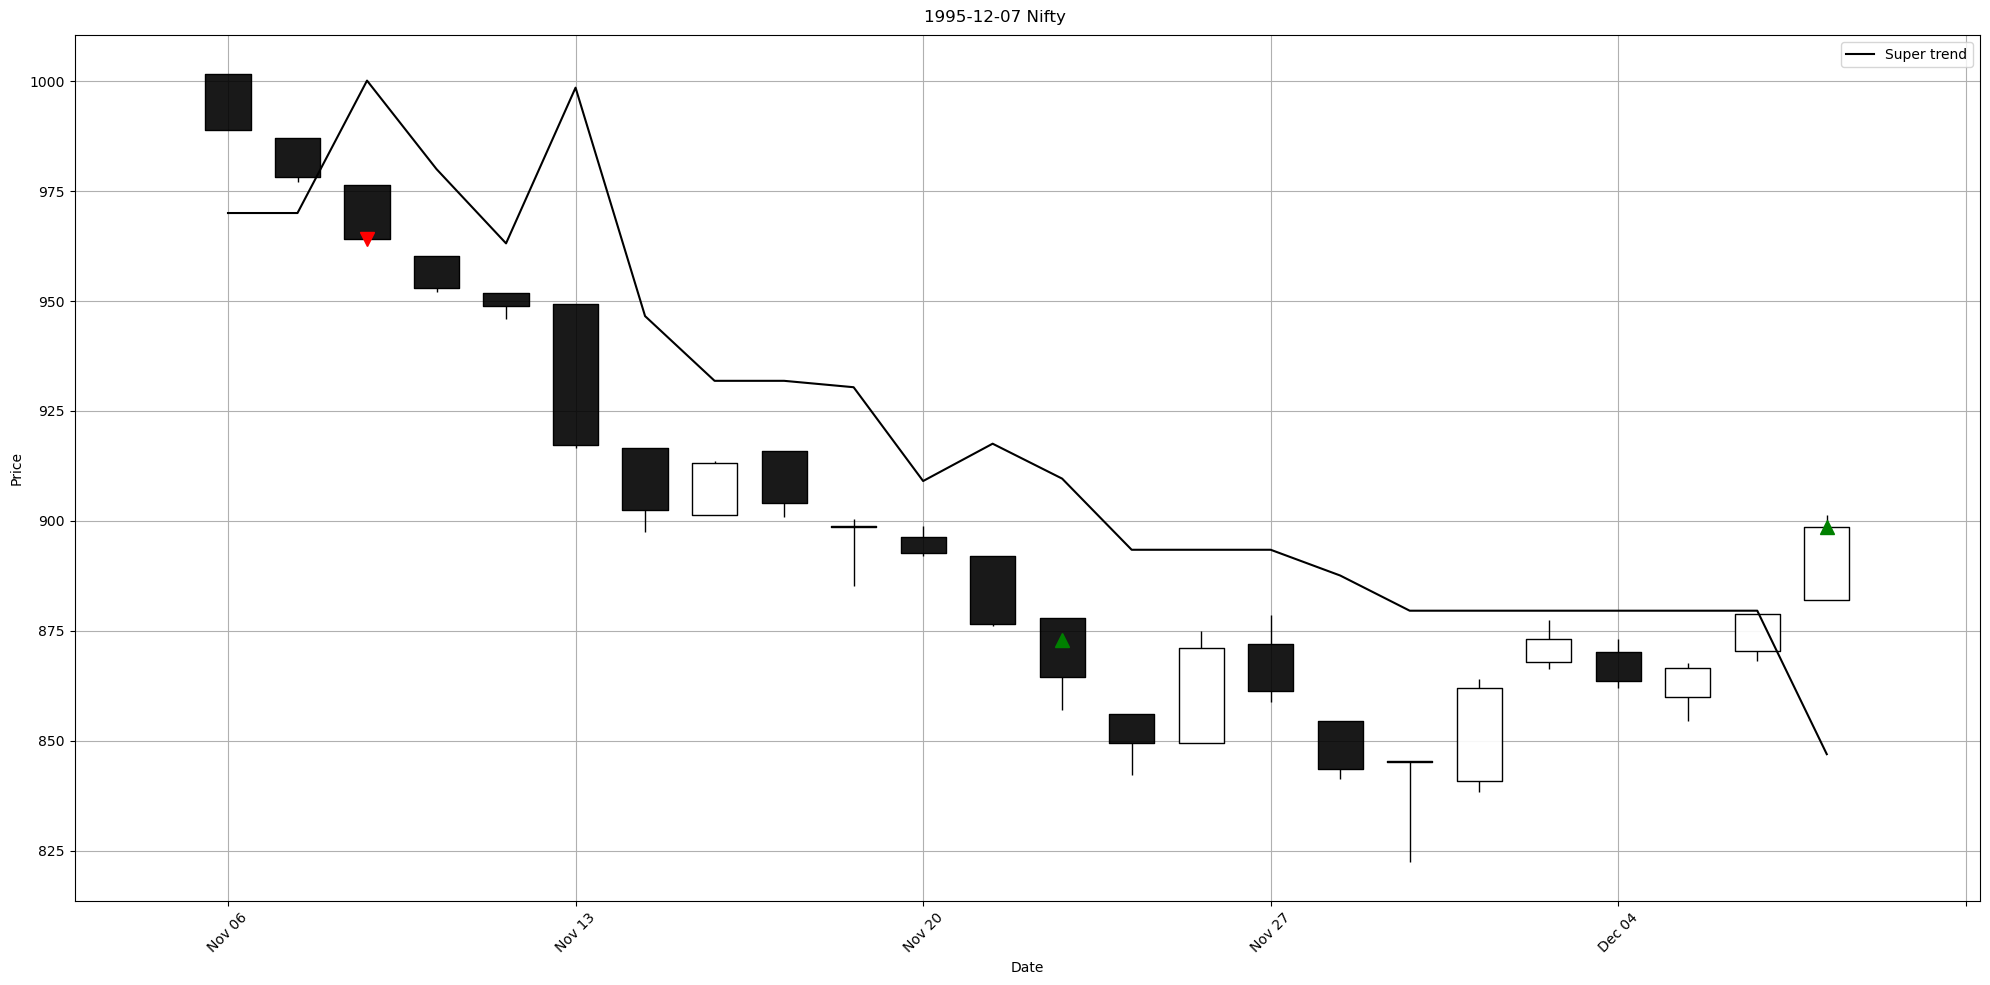

In [45]:
a=1
b=25
plotnifty=nifty
plotnifty.index= pd.to_datetime(plotnifty['Date'])
buytr = np.array(c2['BoughtAt'])
selltr = np.array(c2['SoldAt'])
buytr[ buytr==0 ] = np.nan
selltr[ selltr==0 ] = np.nan
c2['BoughtAt'] = buytr 
c2['SoldAt'] = selltr
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(20,10))
mc = mpf.make_marketcolors(up='w',down='k')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[a:b], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['Supertrend'][a:b].values,'k',label='Super trend')
#plt.plot(c2['Balance'][a*75::f].values,'b',label='5 minute Balance')
plt.plot(c2['BoughtAt'][a:b].values,'g^',markersize=10)
plt.plot(c2['SoldAt'][a:b].values,'rv',markersize=10)
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle(str(nifty[a:b]['Date'].iat[-1])+' '+'Nifty')
fig.tight_layout()
plt.grid()
plt.legend()
#c2[c2['Date']=='12-01-2018'].to_csv('test.csv')
#c2[c2['Date']==trading_days[day]].to_csv('test.csv')